---
title: Linear Shallow Water Model
subject: Jax Approximate Ocean Models
# subtitle: How can I estimate the state AND the parameters?
short_title: Linear SWM
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - CNRS
      - MEOM
    orcid: 0000-0002-6739-0053
    email: jemanjohnson34@gmail.com
  - name: Takaya Uchida
    affiliations:
      - FSU
    orcid: https://orcid.org/0000-0002-8654-6009
    email: tuchida@fsu.edu
license: CC-BY-4.0
keywords: jax, shallow water model, differentiable
abbreviations:
    SW: Shallow Water
    QG: Quasi-Geostrophic
    PDE: Partial Differential Equation
    RHS: Right Hand Side
---

In [1]:
import autoroot
import jax
import jax.numpy as jnp
import numpy as np
import equinox as eqx
import kernex as kex
import finitediffx as fdx
import diffrax as dfx
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import typing as tp
from tqdm.notebook import tqdm, trange
from jaxtyping import Float, Array, PyTree, ArrayLike
import pandas as pd
from jaxsw._src.domain.base import Domain
from jaxsw._src.models.pde import DynamicalSystem
from jaxsw._src.domain.time import TimeDomain
from jaxsw._src.operators.functional import grid as F_grid
from jaxsw._src.models.sw import Params as SWMParams, State as SWMState
from jaxsw._src.models.sw.linear import LinearShallowWater2D

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
jax.config.update("jax_enable_x64", True)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Formulation

$$
\begin{aligned}
\frac{\partial h}{\partial t} &+ H
\left(\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} \right) = 0 \\
\frac{\partial u}{\partial t} &- fv =
- g \frac{\partial h}{\partial x}
- \kappa u \\
\frac{\partial v}{\partial t} &+ fu =
- g \frac{\partial h}{\partial y}
- \kappa v
\end{aligned}
$$ (eq:sw_linear)

## State

Here, we have 3 fields we have to content with:

* $h$ - height
* $u$ - u-velocity (zonal velocity)
* $v$ - v-velocity (meridonal velocity)

So our state will be a container for each of these fields.

In [2]:
SWMState??

Init signature: SWMState(u: jax.Array, v: jax.Array, h: jax.Array)
Docstring:      State(u, v, h)
Source:        
class State(tp.NamedTuple):
    u: Array
    v: Array
    h: Array

    @classmethod
    def init_state(cls, params, init_h=None, init_v=None, init_u=None):
        h = init_h(params) if init_h is not None else State.zero_init(params.domain)
        v = init_v(params) if init_v is not None else State.zero_init(params.domain)
        u = init_u(params) if init_u is not None else State.zero_init(params.domain)
        return cls(u=u, v=v, h=h)
    
    @staticmethod
    def zero_init(domain):
        return jnp.zeros_like(domain.grid[..., 0])
File:           ~/code_projects/jaxsw/jaxsw/_src/models/sw/__init__.py
Type:           type
Subclasses:     

## Domain



For the domain, we will use a generic domain for each of the variables.

In [3]:
dx = dy = 20e3
Lx = 100 * dx
Ly = 101 * dy


domain = Domain(xmin=(0, 0), xmax=(Lx, Ly), dx=(dx, dy))

print(f"Nx: {domain.Nx}")
print(f"Lx: {domain.Lx}")
print(f"dx: {domain.dx}")
print(f"Size: {domain.size}")
print(f"nDims: {domain.ndim}")
print(f"Grid Size: {domain.grid.shape}")
print(f"Cell Volume: {domain.cell_volume:_}")

Nx: (101, 102)
Lx: (2000000.0, 2020000.0)
dx: (20000.0, 20000.0)
Size: (101, 102)
nDims: 2
Grid Size: (101, 102, 2)
Cell Volume: 400_000_000.0


## Initial Condition

**Note**: 
The initial condition depends on a few parameters that will also be used in other examples.
So we can make the parameters container to hold all of the parameters needed.


In [7]:
def init_h0(params):
    """A LOT of work for a lil Gauss bump!"""
    domain = params.domain

    X = domain.grid[..., 0]
    Y = domain.grid[..., 1]

    x_center = domain.coords[0][domain.Nx[0] // 2]
    y_center = domain.coords[1][domain.Nx[1] - 2]

    h0 = params.depth + 1.0 * np.exp(
        -((X - x_center) ** 2) / params.rossby_radius(domain) ** 2
        - (Y - y_center) ** 2 / params.rossby_radius(domain) ** 2
    )

    return jnp.asarray(h0)

In [8]:
SWMParams??

Init signature:
SWMParams(
    domain: jaxsw._src.domain.base.Domain,
    depth: float,
    gravity: float,
    coriolis_f0: float,
    coriolis_beta: float,
)
Docstring:      Params(domain, depth, gravity, coriolis_f0, coriolis_beta)
Source:        
class Params(tp.NamedTuple):
    domain: Domain
    depth: float
    gravity: float
    coriolis_f0: float  # or ARRAY
    coriolis_beta: float  # or ARRAY

    @property
    def phase_speed(self):
        return jnp.sqrt(self.gravity * self.depth)

    def rossby_radius(self, domain):
        return self.phase_speed / self.coriolis_param(domain).mean()
        # return self.phase_speed / self.coriolis_f0

    def coriolis_param(self, domain):
        return self.coriolis_f0 + domain.grid[..., 1] * self.coriolis_beta

    def lateral_viscosity(self, domain):
        return 1e-3 * self.coriolis_f0 * domain.dx[0] ** 2
File:           ~/code_projects/jaxsw/jaxsw/_src/models/sw/__init__.py
Type:           type
Subclasses:     

In [9]:
params = SWMParams(
    depth=100.0, gravity=9.81, coriolis_f0=2e-4, coriolis_beta=2e-11, domain=domain
)

h0 = init_h0(params)

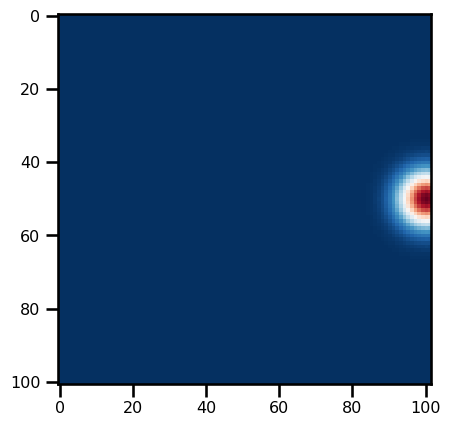

In [10]:
plt.imshow(h0, cmap="RdBu_r")

### State Revisited

Now that we have an initial condition for each of the variables, we can make a small convenience function for the state so that we can initialize it using our initial conditions.
This will make our container more complete

In [11]:
SWMState??

Init signature: SWMState(u: jax.Array, v: jax.Array, h: jax.Array)
Docstring:      State(u, v, h)
Source:        
class State(tp.NamedTuple):
    u: Array
    v: Array
    h: Array

    @classmethod
    def init_state(cls, params, init_h=None, init_v=None, init_u=None):
        h = init_h(params) if init_h is not None else State.zero_init(params.domain)
        v = init_v(params) if init_v is not None else State.zero_init(params.domain)
        u = init_u(params) if init_u is not None else State.zero_init(params.domain)
        return cls(u=u, v=v, h=h)
    
    @staticmethod
    def zero_init(domain):
        return jnp.zeros_like(domain.grid[..., 0])
File:           ~/code_projects/jaxsw/jaxsw/_src/models/sw/__init__.py
Type:           type
Subclasses:     

In [12]:
state_init = SWMState.init_state(params, init_h0)

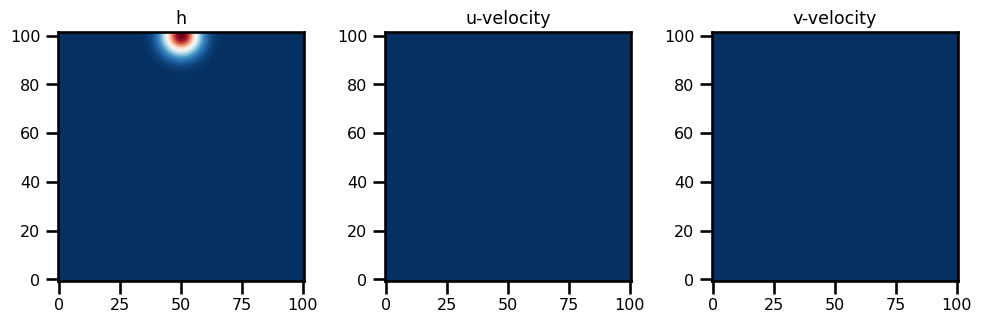

In [13]:
fig, ax = plt.subplots(ncols=3, figsize=(10, 5))
ax[0].imshow(state_init.h.T, origin="lower", cmap="RdBu_r")
ax[0].set(title="h")

ax[1].imshow(state_init.u.T, origin="lower", cmap="RdBu_r")
ax[1].set(title="u-velocity")

ax[2].imshow(state_init.v.T, origin="lower", cmap="RdBu_r")
ax[2].set(title="v-velocity")

plt.tight_layout()
plt.show()

## Equation of Motion

### H RHS

Looking at equation [](#eq:sw_linear), we can look at just the height, $h$, field.
This is given by:

$$
\begin{aligned}
\frac{\partial h}{\partial t} &+ H
\left(\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} \right) = 0
\end{aligned}
$$

Let's write a dedicated function explicitly using this.

In [14]:
LinearShallowWater2D.equation_of_motion_h??

Signature: LinearShallowWater2D.equation_of_motion_h(state, params)
Source:   
    @staticmethod
    def equation_of_motion_h(state, params):
        """
        Equation:
             ∂h/∂t + H (∂u/∂x + ∂v/∂y) = 0
        """
        # parse state container
        h, u, v = state.h, state.u, state.v

        # parse params container
        depth, domain = params.depth, params.domain

        # create empty matrix
        h_rhs = jnp.zeros_like(h)

        # create RHS
        du_dx = fdx.difference(
            u, axis=0, accuracy=1, method="backward", step_size=domain.dx[0]
        )
        dv_dy = fdx.difference(
            v, axis=1, accuracy=1, method="backward", step_size=domain.dx[1]
        )

        # set the interior points only
        h_rhs = h_rhs.at[1:-1, 1:-1].set(
            - depth * (du_dx[1:-1, 1:-1] + dv_dy[1:-1, 1:-1])
        )
        return h_rhs
File:      ~/code_projects/jaxsw/jaxsw/_src/models/sw/linear.py
Type:      function

In [15]:
h_rhs = LinearShallowWater2D.equation_of_motion_h(state_init, params)

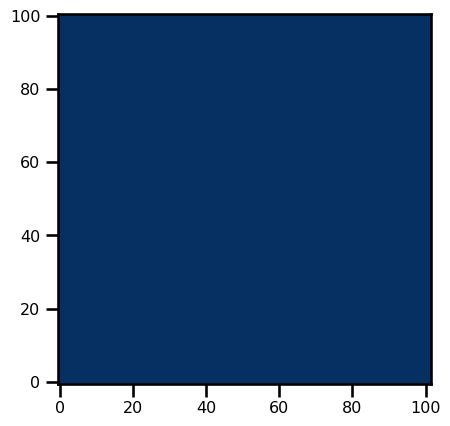

In [16]:
plt.imshow(h_rhs, origin="lower", cmap="RdBu_r")

### U-Velocity

In [17]:
LinearShallowWater2D.equation_of_motion_u??

Signature: LinearShallowWater2D.equation_of_motion_u(state, params)
Source:   
    @staticmethod
    def equation_of_motion_u(state, params):
        """Equation of Motion for the u-component

        Equation:
            ∂u/∂t = fv - g ∂h/∂x
        """
        # parse state and params
        h, u, v = state.h, state.u, state.v
        gravity, domain = params.gravity, params.domain
        
        coriolis = params.coriolis_param(domain)

        u_rhs = jnp.zeros_like(u)

        v_avg = F_grid.center_average_2D(v[1:,:-1], padding="valid")
        v_avg *= coriolis[1:-1,1:-1]

        dh_dx = fdx.difference(
            h, axis=0, accuracy=1, method="forward", step_size=domain.dx[0]
        )
        dh_dx *= - gravity


        u_rhs = u_rhs.at[1:-1, 1:-1].set(v_avg + dh_dx[1:-1, 1:-1])

        return u_rhs
File:      ~/code_projects/jaxsw/jaxsw/_src/models/sw/linear.py
Type:      function

In [18]:
u_rhs = LinearShallowWater2D.equation_of_motion_u(state_init, params)

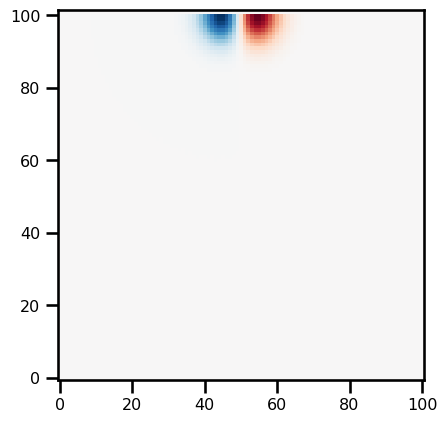

In [19]:
plt.imshow(u_rhs.T, origin="lower", cmap="RdBu_r")

### V-Velocity

In [20]:
LinearShallowWater2D.equation_of_motion_v??

Signature: LinearShallowWater2D.equation_of_motion_v(state, params)
Source:   
    @staticmethod
    def equation_of_motion_v(state, params):
        """Equation of motion for v-component
        Equation:
            ∂v/∂t = - fu - g ∂h/∂y
        """
        # parse state and parameters
        h, u, v = state.h, state.u, state.v
        gravity, domain = params.gravity, params.domain
        
        coriolis = params.coriolis_param(domain)
        

        v_rhs = jnp.zeros_like(v)

        u_avg = F_grid.center_average_2D(u[:-1, 1:], padding="valid")
        u_avg *= - coriolis[1:-1,1:-1]

        dh_dy = fdx.difference(
            h, axis=1, accuracy=1, method="forward", step_size=domain.dx[1]
        )
        dh_dy *= -gravity

        v_rhs = v_rhs.at[1:-1, 1:-1].set(u_avg + dh_dy[1:-1, 1:-1])
        return v_rhs
File:      ~/code_projects/jaxsw/jaxsw/_src/models/sw/linear.py
Type:      function

In [21]:
v_rhs = LinearShallowWater2D.equation_of_motion_v(state_init, params)

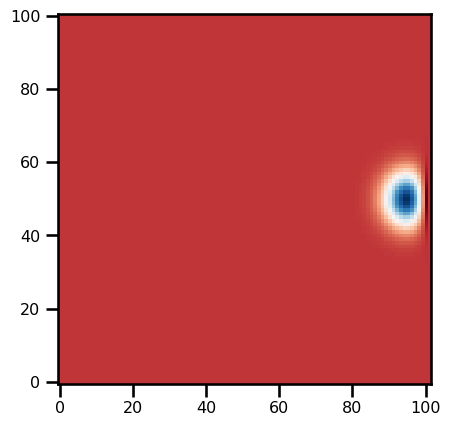

In [22]:
plt.imshow(v_rhs, origin="lower", cmap="RdBu_r")

### Boundary Conditions

In [23]:
# initialize state
state_init = SWMState.init_state(params, init_h0)

# apply boundary conditions
state_init = LinearShallowWater2D.boundary_f(state_init, "h")
state_init = LinearShallowWater2D.boundary_f(state_init, "u")
state_init = LinearShallowWater2D.boundary_f(state_init, "v")

# apply RHS
h_rhs = LinearShallowWater2D.equation_of_motion_h(state_init, params)
v_rhs = LinearShallowWater2D.equation_of_motion_v(state_init, params)
u_rhs = LinearShallowWater2D.equation_of_motion_u(state_init, params)

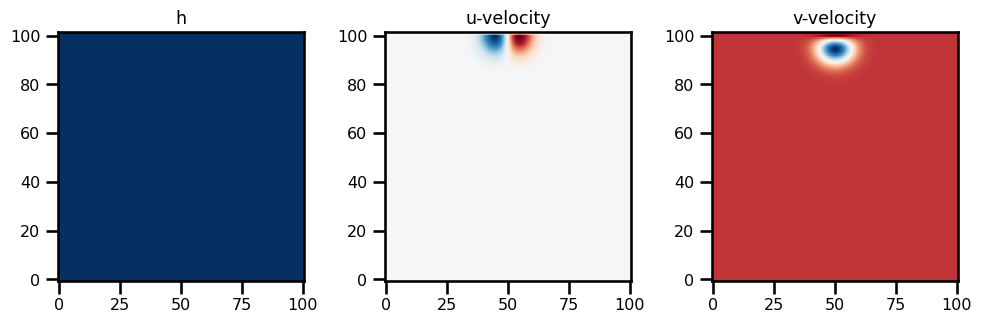

In [24]:
fig, ax = plt.subplots(ncols=3, figsize=(10, 5))
ax[0].imshow(h_rhs.T, origin="lower", cmap="RdBu_r")
ax[0].set(title="h")

ax[1].imshow(u_rhs.T, origin="lower", cmap="RdBu_r")
ax[1].set(title="u-velocity")

ax[2].imshow(v_rhs.T, origin="lower", cmap="RdBu_r")
ax[2].set(title="v-velocity")

plt.tight_layout()
plt.show()

In [25]:
state_update = LinearShallowWater2D.equation_of_motion(0, state_init, params)

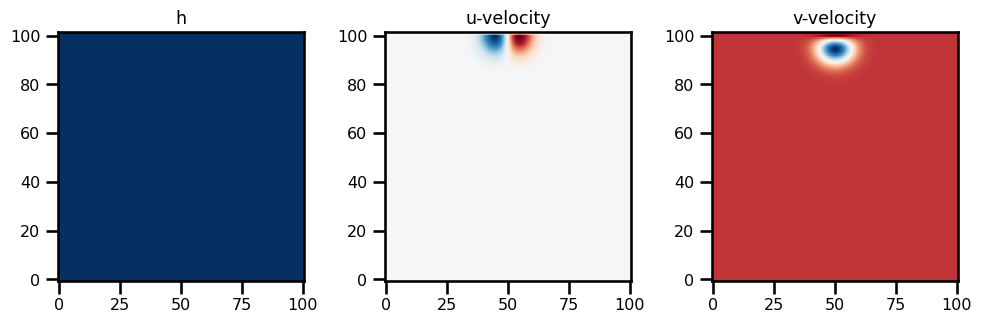

In [26]:
fig, ax = plt.subplots(ncols=3, figsize=(10, 5))
ax[0].imshow(h_rhs.T, origin="lower", cmap="RdBu_r")
ax[0].set(title="h")

ax[1].imshow(u_rhs.T, origin="lower", cmap="RdBu_r")
ax[1].set(title="u-velocity")

ax[2].imshow(v_rhs.T, origin="lower", cmap="RdBu_r")
ax[2].set(title="v-velocity")

plt.tight_layout()
plt.show()

## Time Stepping

In [27]:
# TEMPORAL DISCRETIZATION
# initialize temporal domain

dt = 0.25 * domain.dx[0] / np.sqrt(params.gravity * params.depth)
print(f"Step Size (dt): {dt:.4e}")

tmin = 0.0
tmax = pd.to_timedelta(5, unit="days").total_seconds()
num_save = 100

Step Size (dt): 1.5964e+02


In [28]:
import pandas as pd

In [29]:
t_domain = TimeDomain(tmin=tmin, tmax=tmax, dt=dt)
ts = jnp.linspace(tmin, tmax, num_save)
saveat = dfx.SaveAt(ts=ts)

# DYNAMICAL SYSTEM
dyn_model = LinearShallowWater2D(t_domain=t_domain, saveat=saveat)

### Integration

In [30]:
# Euler, Constant StepSize
solver = dfx.Tsit5()

# Tolerances
stepsize_controller = dfx.ConstantStepSize()
# rtol = 1e-3
# atol = 1e-4
# stepsize_controller = dfx.PIDController(
#     pcoeff=0.3, icoeff=0.4, rtol=rtol, atol=atol, dtmax=dt
# )

# SPATIAL DISCRETIZATION
params_init = SWMParams(
    depth=100.0, gravity=9.81, coriolis_f0=2e-4, coriolis_beta=2e-11, domain=domain
)
state_init = SWMState.init_state(params_init, init_h0)


# integration
sol = dfx.diffeqsolve(
    terms=dfx.ODETerm(dyn_model.equation_of_motion),
    solver=solver,
    t0=ts.min(),
    t1=ts.max(),
    dt0=dt,
    y0=state_init,
    saveat=saveat,
    args=params_init,
    stepsize_controller=stepsize_controller,
    max_steps=None,
)

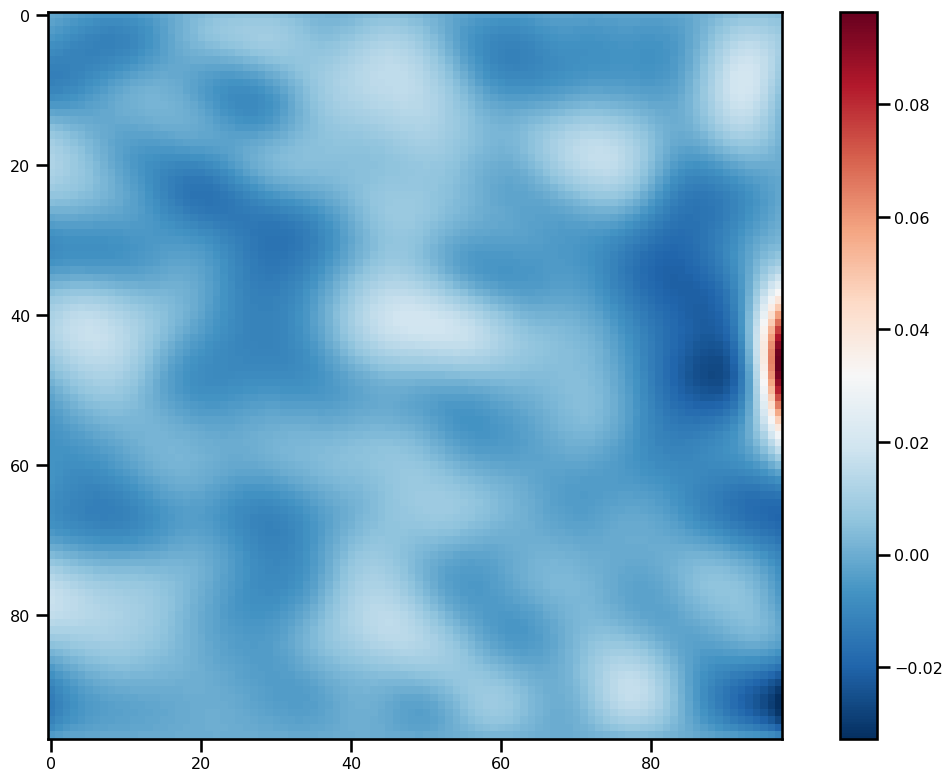

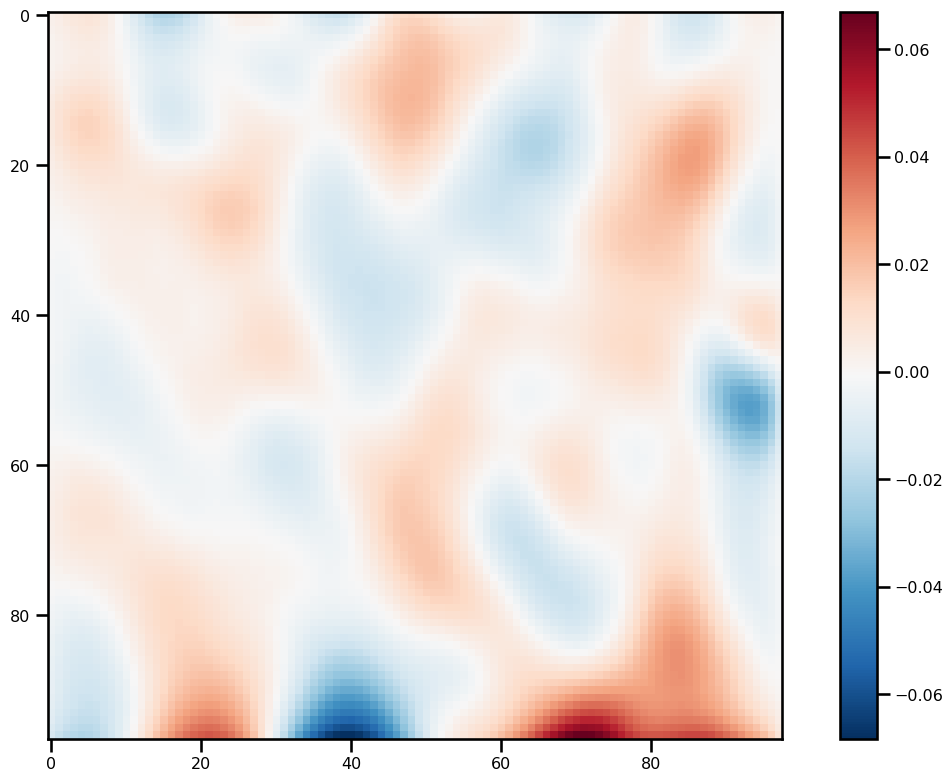

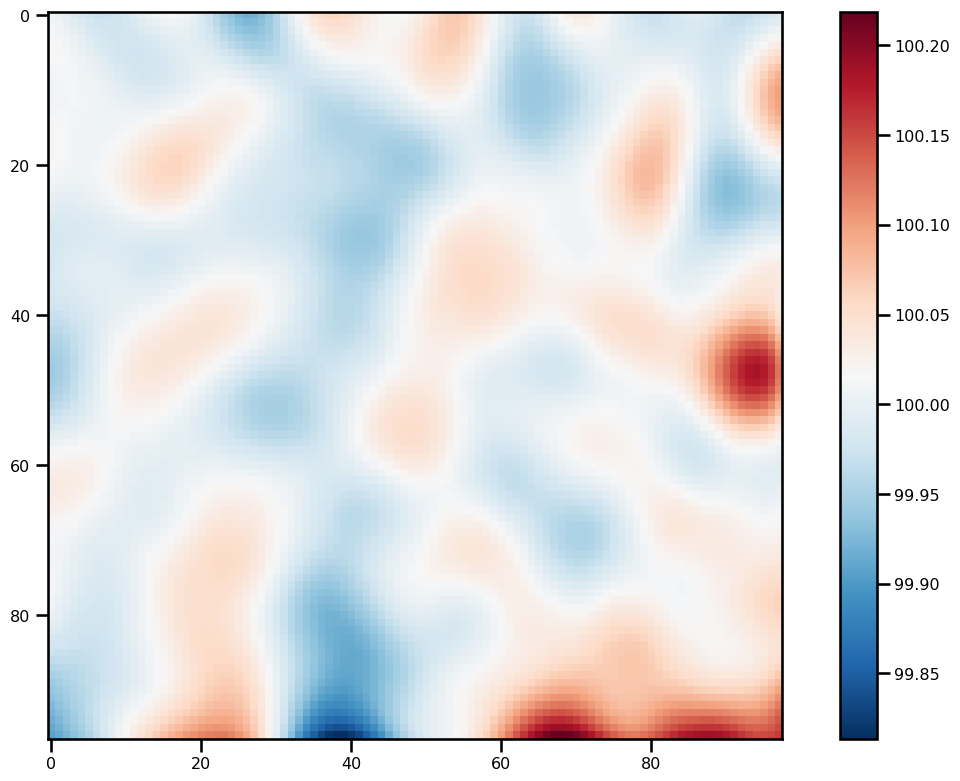

In [31]:
for ivar in sol.ys:
    fig, ax = plt.subplots(figsize=(12, 8))
    pts = ax.imshow(ivar[-1][2:-2, 2:-2], cmap="RdBu_r")
    plt.colorbar(pts)
    plt.tight_layout()

## Analysis

In [32]:
ds_results = xr.Dataset(
    data_vars={
        "u": (("time", "x", "y"), sol.ys.u),
        "v": (("time", "x", "y"), sol.ys.v),
        "h": (("time", "x", "y"), sol.ys.h),
    },
    coords={
        "time": (("time"), sol.ts),
        "x": (("x"), domain.coords[0]),
        "y": (("y"), domain.coords[1]),
    },
)
ds_results

<xarray.Dataset>
Dimensions:  (time: 100, x: 101, y: 102)
Coordinates:
  * time     (time) float64 0.0 4.364e+03 8.727e+03 ... 4.276e+05 4.32e+05
  * x        (x) float64 0.0 2e+04 4e+04 6e+04 ... 1.96e+06 1.98e+06 2e+06
  * y        (y) float64 0.0 2e+04 4e+04 6e+04 ... 1.98e+06 2e+06 2.02e+06
Data variables:
    u        (time, x, y) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    v        (time, x, y) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    h        (time, x, y) float64 100.0 100.0 100.0 100.0 ... 100.0 100.0 100.0

In [33]:
from xmovie import Movie
from pathlib import Path
from matplotlib import ticker


def custom_plot_p_layers(ds, fig, tt, *args, **kwargs):
    sub = ds.isel(time=tt)
    time = sub.v.time.values / 86400

    xlim = kwargs.pop("xlim", None)
    ylim = kwargs.pop("ylim", None)
    vmin = kwargs.pop("vmin", sub.h.isel(x=slice(1, -1), y=slice(1, -1)).min())
    vmax = kwargs.pop("vmax", sub.h.isel(x=slice(1, -1), y=slice(1, -1)).max())
    cmap = kwargs.pop("cmap", "viridis")

    fig.set_size_inches(15, 4.5)

    ax = fig.subplots(
        ncols=3,
    )

    # HEIGHT
    cbar_kwargs = {"label": "Height [m]"}
    pts = sub.h.isel(x=slice(1, -1), y=slice(1, -1)).plot.pcolormesh(
        ax=ax[0],
        cmap="viridis",
        add_colorbar=True,
        vmin=vmin,
        vmax=vmax,
        cbar_kwargs=cbar_kwargs,
        # **kwargs
    )
    loc = ticker.MaxNLocator(6)
    levels = loc.tick_values(vmin, vmax)
    sub.h.isel(x=slice(1, -1), y=slice(1, -1)).plot.contour(
        ax=ax[0],
        levels=levels,
        vmin=vmin,
        vmax=vmax,
        alpha=0.5,
        linewidths=1,
        cmap="black",
        linestyles=np.where(levels >= 0, "-", "--"),
    )

    # ax.set_aspect('equal')
    pts = ax[0].set(xlabel="x [m]", ylabel="y [m]", title=f"Time: {time:.4f} day(s)")

    # U-VELOCITY
    cbar_kwargs = {"label": "U-Velocity [ms$^{-1}$]"}
    vmin = sub.u.isel(x=slice(1, -2), y=slice(1, -1)).min()
    vmax = sub.u.isel(x=slice(1, -2), y=slice(1, -1)).max()
    pts = sub.u.isel(x=slice(1, -2), y=slice(1, -1)).plot.pcolormesh(
        ax=ax[1],
        cmap="coolwarm",
        add_colorbar=True,
        vmin=vmin,
        vmax=vmax,
        cbar_kwargs=cbar_kwargs
        # **kwargs
    )
    loc = ticker.MaxNLocator(6)
    levels = loc.tick_values(vmin, vmax)
    sub.u.isel(x=slice(1, -2), y=slice(1, -1)).plot.contour(
        ax=ax[1],
        levels=levels,
        vmin=vmin,
        vmax=vmax,
        alpha=0.5,
        linewidths=1,
        cmap="black",
        linestyles=np.where(levels >= 0, "-", "--"),
    )

    # ax.set_aspect('equal')
    pts = ax[1].set(xlabel="x [m]", ylabel="y [m]", title=f"Time: {time:.4f} day(s)")

    # V-VELOCITY
    cbar_kwargs = {"label": "V-Velocity [ms$^{-1}$]"}
    vmin = sub.v.isel(x=slice(1, -1), y=slice(1, -2)).min()
    vmax = sub.v.isel(x=slice(1, -1), y=slice(1, -2)).max()
    pts = sub.v.isel(x=slice(1, -1), y=slice(1, -2)).plot.pcolormesh(
        ax=ax[2],
        cmap="coolwarm",
        add_colorbar=True,
        vmin=vmin,
        vmax=vmax,
        cbar_kwargs=cbar_kwargs
        # **kwargs
    )
    loc = ticker.MaxNLocator(6)
    levels = loc.tick_values(vmin, vmax)
    sub.v.isel(x=slice(1, -1), y=slice(1, -2)).plot.contour(
        ax=ax[2],
        levels=levels,
        vmin=vmin,
        vmax=vmax,
        alpha=0.5,
        linewidths=1,
        cmap="black",
        linestyles=np.where(levels >= 0, "-", "--"),
    )

    # ax.set_aspect('equal')

    pts = ax[2].set(xlabel="x [m]", ylabel="y [m]", title=f"Time: {time:.4f} day(s)")

    plt.tight_layout()
    return None, None


from xmovie import Movie
from pathlib import Path
from matplotlib import ticker


def custom_plot_h_ke_layers(ds, fig, tt, *args, **kwargs):
    sub = ds.isel(time=tt)
    time = sub.v.time.values / 86400

    xlim = kwargs.pop("xlim", None)
    ylim = kwargs.pop("ylim", None)
    vmin = kwargs.pop("vmin", sub.h.isel(x=slice(1, -1), y=slice(1, -1)).min())
    vmax = kwargs.pop("vmax", sub.h.isel(x=slice(1, -1), y=slice(1, -1)).max())
    cmap = kwargs.pop("cmap", "viridis")

    fig.set_size_inches(10, 4.5)

    ax = fig.subplots(
        ncols=2,
    )

    # HEIGHT
    cbar_kwargs = {"label": "Height [m]"}
    pts = sub.h.isel(x=slice(1, -1), y=slice(1, -1)).plot.pcolormesh(
        ax=ax[0],
        cmap="viridis",
        add_colorbar=True,
        vmin=vmin,
        vmax=vmax,
        cbar_kwargs=cbar_kwargs,
        # **kwargs
    )
    loc = ticker.MaxNLocator(6)
    levels = loc.tick_values(vmin, vmax)
    sub.h.isel(x=slice(1, -1), y=slice(1, -1)).plot.contour(
        ax=ax[0],
        levels=levels,
        vmin=vmin,
        vmax=vmax,
        alpha=0.5,
        linewidths=1,
        cmap="black",
        linestyles=np.where(levels >= 0, "-", "--"),
    )

    # ax.set_aspect('equal')
    pts = ax[0].set(xlabel="x [m]", ylabel="y [m]", title=f"Time: {time:.4f} day(s)")

    # U-VELOCITY
    sub["ke"] = np.sqrt(0.5 * (sub.u**2 + sub.v**2))
    cbar_kwargs = {"label": "√ Kinetic Energy [ms$^{-1}$]"}
    vmin = sub.ke.isel(x=slice(1, -2), y=slice(1, -2)).min()
    vmax = sub.ke.isel(x=slice(1, -2), y=slice(1, -2)).max()
    pts = sub.ke.isel(x=slice(1, -2), y=slice(1, -2)).plot.pcolormesh(
        ax=ax[1],
        cmap="YlGnBu_r",
        add_colorbar=True,
        vmin=vmin,
        vmax=vmax,
        cbar_kwargs=cbar_kwargs
        # **kwargs
    )
    loc = ticker.MaxNLocator(6)
    levels = loc.tick_values(vmin, vmax)
    sub.ke.isel(x=slice(1, -2), y=slice(1, -2)).plot.contour(
        ax=ax[1],
        levels=levels,
        vmin=vmin,
        vmax=vmax,
        alpha=0.5,
        linewidths=1,
        cmap="black",
        linestyles=np.where(levels >= 0, "-", "--"),
    )

    # ax.set_aspect('equal')
    pts = ax[1].set(xlabel="x [m]", ylabel="y [m]", title=f"Time: {time:.4f} day(s)")

    plt.tight_layout()
    return None, None


from pathlib import Path


def create_movie(
    var,
    name,
    plotfunc=custom_plot_p_layers,
    framedim: str = "steps",
    file_path=None,
    **kwargs,
):
    if file_path is not None:
        file_name = Path(file_path).joinpath(f"movie_{name}.gif")
    else:
        file_name = Path(f"./movie_{name}.gif")

    mov = Movie(
        var, plotfunc=plotfunc, framedim=framedim, **kwargs, dpi=200, input_check=False
    )
    mov.save(
        file_name,
        remove_movie=False,
        progress=True,
        framerate=3,
        gif_framerate=3,
        overwrite_existing=True,
        gif_resolution_factor=0.5,
        parallel=False,
    )

    return None

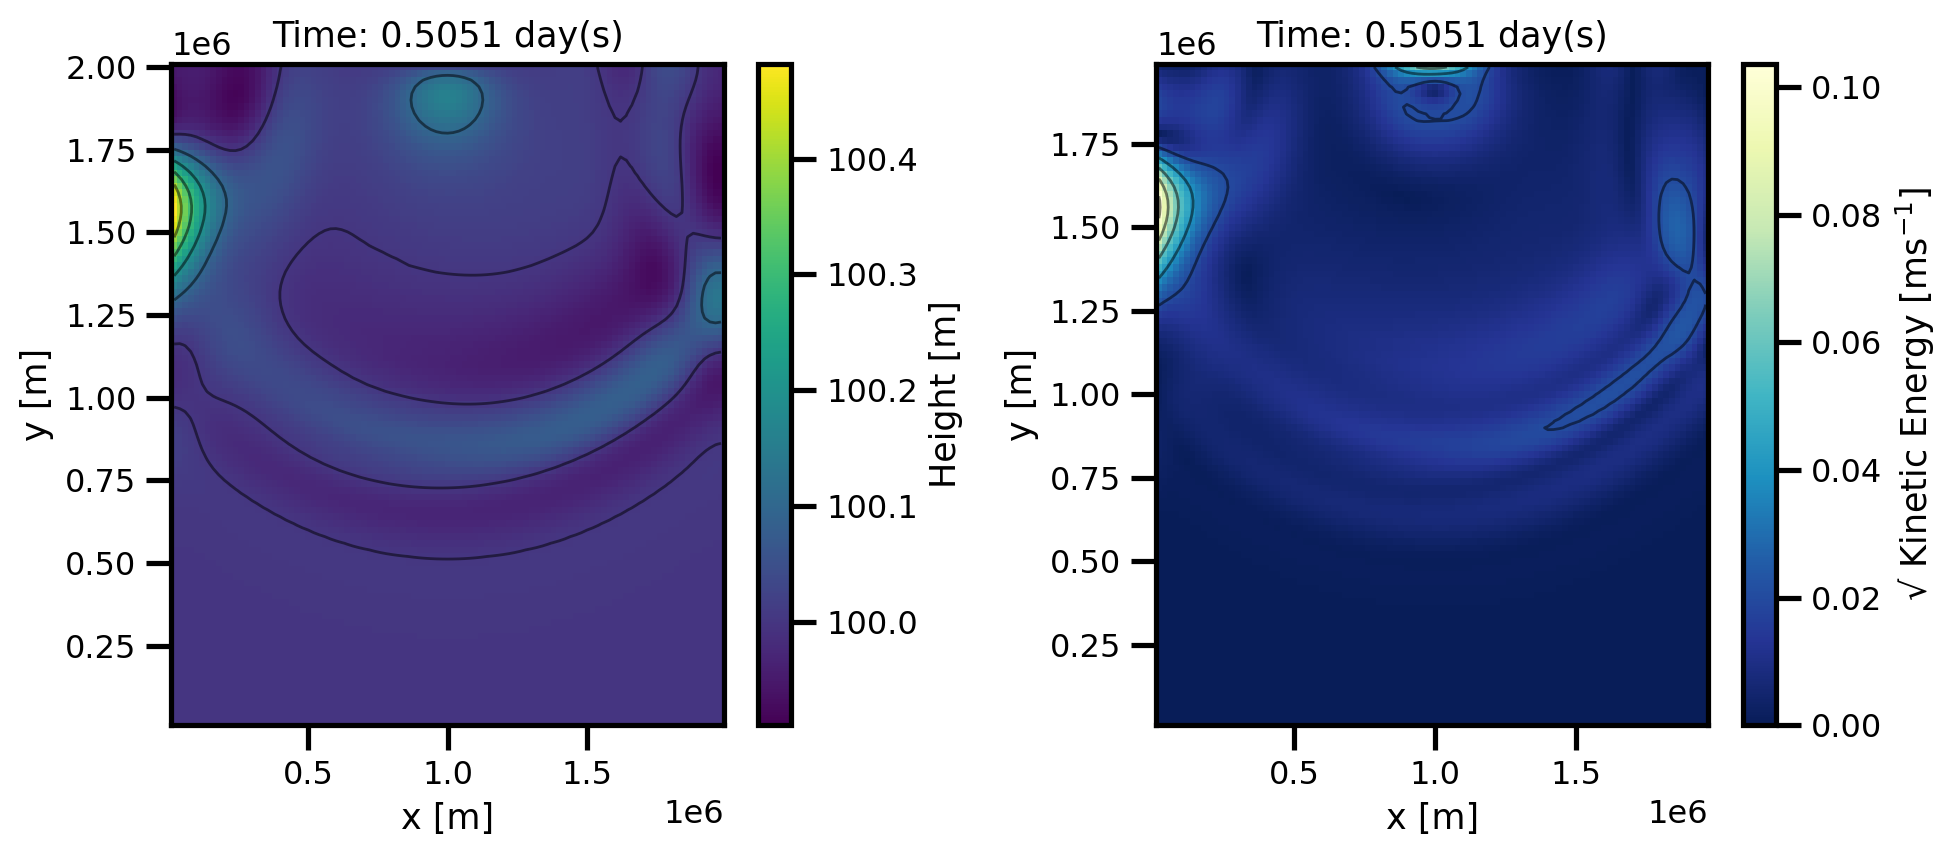

In [37]:
%matplotlib inline
mov = Movie(
    ds_results.transpose("time", "y", "x"),
    plotfunc=custom_plot_h_ke_layers,
    framedim="time",
    input_check=False,
)
mov.preview(10)

In [36]:
create_movie(
    ds_results.transpose(
        "time", "y", "x"
    ),  # .sel(time=slice("2017-02-01", "2017-03-01")),
    name="swe_linear_rossby",
    plotfunc=custom_plot_h_ke_layers,
    file_path="./",
    framedim="time",
    cmap="viridis",
    robust=True,
)

  0%|          | 0/100 [00:00<?, ?it/s]

Movie created at movie_swe_linear_rossby.mp4
GIF created at movie_swe_linear_rossby.gif
